No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem


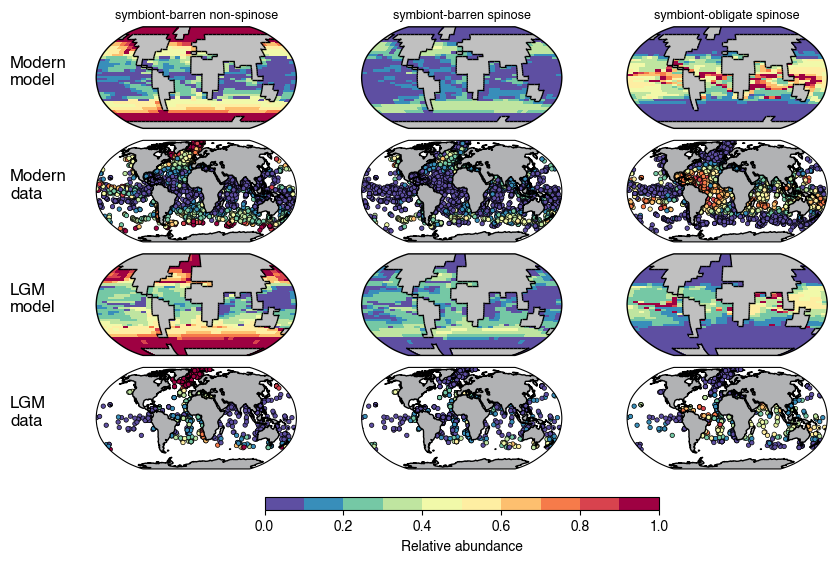

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.transforms as mtransforms
import numpy as np

from cgeniepy.ecology import EcoModel
from cgeniepy.plot import scatter_map
from cgeniepy.array import GenieArray

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.weight'] = 'bold'

def get_abundance(model, foram):
    """
    convert biomass to absolute abundance 
    """
    ## mmol C/m3 => ind/m3

    ## biovolume in um3
    biovolume = model.eco_pars().query(f"PFT == 'foram_{foram}'")['volume']
    ## biomass density in g C/um3
    density = 8.9E-14
    
    ## get biomass per individual
    biomass_per_ind =  biovolume * density
    
    ## get biomass field
    biomass = model.get_foram(foram).isel(time=-1).array

    ## filter those with less than 1 cell/m3
    biomass = biomass.where(biomass > biomass_per_ind.values, biomass, 0)

    ## convert biomass to abundance
    abundance = biomass / biomass_per_ind.values    

    return abundance

def get_rel_abun(model, foram):

    all_foram = ['bn','bs','sn','ss']
    total_abundance = np.zeros([36, 36])
    ## get total foram abundance
    for f in all_foram:
        total_abundance += get_abundance(model, f)

    ## get relative abundance
    ra = get_abundance(model, foram) / total_abundance

    ## return GenieArray
    genie_array = GenieArray()
    genie_array.array = ra
    return genie_array

fig, axes = plt.subplots(nrows=4, ncols=3,
                         figsize=(9, 6),
                         subplot_kw=dict(projection=ccrs.Robinson()))

# OBSERVATION DATA
forcens = pd.read_csv("~/Science/lgm_foram_census/tidy/forcens_fg_r_tidy.csv")
lgm = pd.read_csv("~/Science/lgm_foram_census/tidy/lgm_fg_r_tidy.csv")
lgm = lgm[lgm['Data_Source'] == 'margo']

# MODELS
mod_pi = EcoModel("../model/muffin.CBE.worlg4.BASESFeTDTL.SPIN")
mod_lgm = EcoModel("../model/muffin.CBE.GIteiiva.BASESFeTDTL_rb.SPIN")

c = plt.get_cmap("Spectral_r", 10)

## letters = list(map(chr, range(97, 97+4))) #97 is "a"
letters = ['Modern\nmodel', 'Modern\ndata', 'LGM\nmodel', 'LGM\ndata']
name_list = ["bn", "bs", "ss"]
longname_list = ["symbiont-barren non-spinose",
                 "symbiont-barren spinose",
                 "symbiont-obligate spinose"]


for i, ax in enumerate(axes.flat):
    #labelling
    if i%3 == 0:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(-0.5, 0.5, letters[i//3], transform=ax.transAxes + trans, weight="bold", fontsize=12)
    if i < 3:
        # plot modern model
        index = i
        get_rel_abun(mod_pi, name_list[index]).plot(ax=ax, vmin=0, vmax=1, cmap=c, colorbar=False)
        ax.set_title(longname_list[i], fontsize=9)
    elif i < 6 :
        # forcens data
        index = i-3
        forcens_subset = forcens[['Latitude','Longitude',longname_list[index]]]
        scatter_map(df=forcens_subset, var=longname_list[index],ax=ax, vmin=0, vmax=1, cmap=c,s=10)
    elif i < 9:
        # plot modern model
        index = i - 6
        p = get_rel_abun(mod_lgm, name_list[index]).plot(ax=ax, vmin=0,vmax=1, cmap=c, colorbar=False)
    elif i < 12:
        # margo data
        index = i-9
        lgm_subset = lgm[['Latitude','Longitude',longname_list[index]]]
        scatter_map(ax=ax, df=lgm_subset, var=longname_list[index], vmin=0, vmax=1, cmap=c,s=10,
                    interpolate=False)

fig.tight_layout()
cbar = fig.colorbar(p, ax=axes.flatten().tolist(),orientation="horizontal", pad=0.05, aspect=30, shrink=0.5)
cbar.set_label("Relative abundance")

fig.savefig("../output/ext_data_fig1.png", dpi=400, bbox_inches='tight')

In [2]:
def biomass_conversion(l, bcf, mole_unit=True):
    """convert abundace to biomass
    L: length of foram, unit: μm
    BCF: biomass conversion factor, unit: μg C / μm^3
    
    return biomass per foram cell, unit: μg C / foram cell
    
    if mole_unit is True, return biomass per foram cell, unit: mmol C / foram cell    
    """
    if mole_unit:
        return l**3 * bcf / 12 * 1e-3
    else:
        return l**3 * bcf

biomass_conversion(250, 1.1645E-7)

0.0001516276041666667